In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import model_selection, preprocessing
from operator import add, sub

sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=1))

In [24]:
class NN(object):

    def __init__(self, n_nodes):
        self.n_nodes = n_nodes
        self.n_layers = len(n_nodes)
        self.weights, self.bias = self.init_weights()

    def train(self, X, y, lr=1, epochs=100, batch_size=1):
        """
        Train the neural network using stochastic gradient descent to iteratively 
        update weights and biases.
        :param X: Predictor variable matrix in, where variables are columns and samples are rows.
        :param y: Target variable vector.
        :param lr: Learning Rate.
        :param epochs: Number of views of entire training data set that the net will see.
        :param batch_size: number of batches per epoch.
        :return:
        """
        N = len(X)
        errors = []

        for e in np.arange(epochs):
            X, y = self.shuffle_data(X, y)

            X_batches = np.array(
                [X[k:k + batch_size]
                 for k in np.arange(0, N, batch_size)])
            y_batches = np.array(
                [y[k:k + batch_size]
                 for k in np.arange(0, N, batch_size)])

            for xb, yb in zip(X_batches, y_batches):
                self.update(xb, yb, lr)

            y_hat = self.feed_forward(X)
            errors.append(self.cross_entropy_ave(y, y_hat))

        plt.title('Train Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Cross Entropy')
        plt.plot(errors)
        plt.show()


    def feed_forward(self, X, train=False):
        """
        Get probabilities of classifications based on predictor matrix X, current weights and biases.
        """
        a = np.atleast_2d(X).T
        N = len(self.n_nodes)
        iters = np.arange(1, N)
        activations = [a]
        zs = []
        for i, b, w in zip(iters, self.bias, self.weights):
            a = self.activate_logistic(a, w, b)
            if train:
                activations.append(a)
                zs.append(w @ activations[i - 1] + b)

        if train:
            return activations, zs
        return a

    def back_prop(self, X, Y, debug=False):
        """
        Back propogate error for use in gradient descent.
        """
        del_w = np.array([np.zeros(w.shape) for w in self.weights])
        del_b = np.array([np.zeros(b.shape) for b in self.bias])

        # feed forward:
        A, Z = self.feed_forward(X, train=True)

        # get error heuristic of output layer:
        delta_l = self.cost_derivative(Y, A[-1]) * self.sigmoid_prime(Z[-1])
        del_w[-1] = delta_l @ A[-2].T
        del_b[-1] = delta_l

        # back propagate:
        for i in np.arange(2, self.n_layers):
            sp = self.sigmoid_prime(Z[-i])
            delta_l = (self.weights[-i + 1].T @ delta_l) * sp
            del_b[-i] = delta_l
            del_w[-i] = delta_l @ A[-i - 1].T

        return del_w, del_b

    # helper functions --------------------
    def update(self, X, Y, lr):
        """
        Update weights and biases based on back propagated error.
        """
        N = len(X)
        nabla_b = np.array([np.zeros(b.shape) for b in self.bias])
        nabla_w = np.array([np.zeros(w.shape) for w in self.weights])

        for x, y in zip(X, Y):
            delta_dw, delta_db = self.back_prop(x, y)
            nabla_w += delta_dw
            nabla_b += delta_db

        self.weights -= lr * np.array(list(map(lambda x: x / N, nabla_w)))
        self.bias -= lr * np.array(list(map(lambda x: x / N, nabla_b)))

    def activate_logistic(self, X, weights, bias):
        """
        Apply sigmoid activation function to weighted sum  WX + b
        """
        return expit(weights @ X + bias)

    def activate_softmax(self, X, weights, bias):
        Z = weights @ X + b
        return np.exp(Z[i]) / np.exp(Z).sum()

    def sigmoid_prime(self, X):
        return expit(X) * (1 - expit(X))

    # cross entropy loss derivative wrt final activation layer
    def cost_derivative(self, y, y_hat):
        return (y_hat - y) / (1e-14 + y_hat * (1 - y_hat))

    def init_weights(self):
        weights = np.array([np.random.randn(m, n) for m, n in zip(self.n_nodes[1:], self.n_nodes[:-1])])
        bias = np.array([np.zeros(m).reshape(-1, 1) for m in self.n_nodes[1:]])
        return weights, bias

    def shuffle_data(self, X, y):
        N = len(X)
        idx = np.arange(N)
        np.random.shuffle(idx)
        return X[idx], y[idx]

    def cross_entropy_ave(self, y, y_hat):
        return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

In [34]:
np.random.seed(44)
net = NN((3,2,1))

In [35]:
data = pd.read_csv('student_data.csv')
data.head(10)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


In [36]:
data = preprocessing.minmax_scale(data, feature_range=(0,1))
X = data[:, 1:]
y = data[:, 0]
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y)

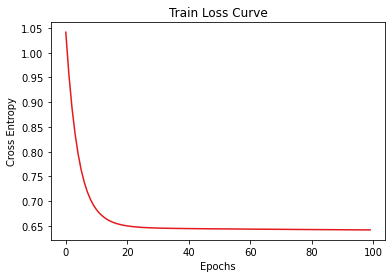

In [37]:
lr=.1
epochs=100
batch_size = 100
net.train(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)

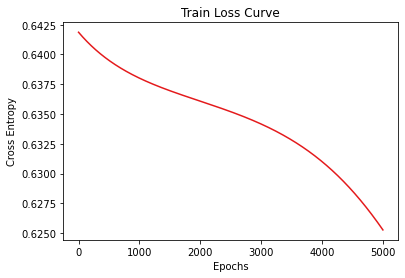

In [38]:
lr = .05
epochs = 5000
batch_size = 400
net.train(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)

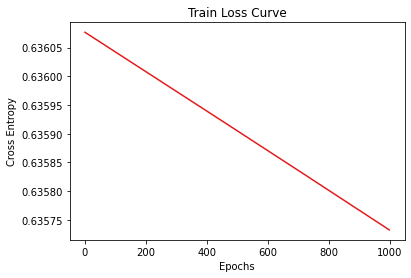

In [30]:
lr = .01
epochs = 1000
net.train(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)

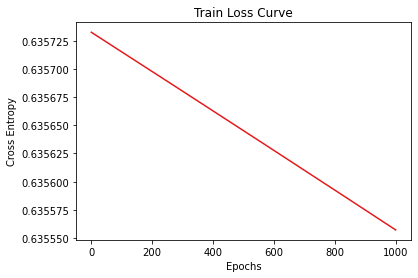

In [31]:
lr = .005
epochs = 1000
net.train(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)

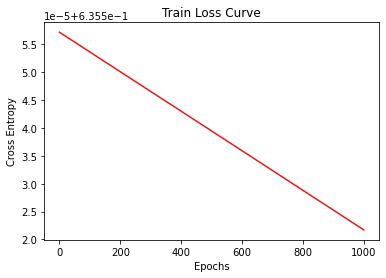

In [32]:
lr = .001
epochs = 1000
net.train(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)

In [33]:
a_L = net.feed_forward(x_test)
# Predictions: 
admit = (a_L >= 0.5)
# Accuracy:
(admit == y_test).mean()

0.73